# Test 4 : Critical k

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from pathlib import Path
import sys
import seaborn as sns

## Time wise


In [15]:


# Try to get the script directory; if in a notebook, use the current working directory
try:
    SCRIPT_DIR = Path(__file__).resolve().parent
except NameError:
    # We are in a notebook/interactive session
    SCRIPT_DIR = Path(os.getcwd()).resolve()

# Adjust this based on where your 'logs' folder is relative to the notebook
# If 'logs' is in the same folder as your notebook, use SCRIPT_DIR
# If 'logs' is one level up, use SCRIPT_DIR.parent
PROJECT_ROOT = SCRIPT_DIR.parent

LOG_FILE = PROJECT_ROOT / "logs" / "time_crit_k.csv"
PLOT_DIR = PROJECT_ROOT / "logs" / "plots"

print(f"Looking for log file at: {LOG_FILE}")

Looking for log file at: /Users/nautilus/gridfw/logs/time_crit_k.csv


In [16]:

def load_data():
    if not os.path.exists(LOG_FILE):
        print(f"Error: Log file not found at {LOG_FILE}")
        sys.exit(1)

    try:
        df = pd.read_csv(LOG_FILE)
        # Clean column names (remove spaces)
        df.columns = df.columns.str.strip()
        df.columns = df.columns.str.lower()
        
        # Filter acceptable speedup
        df['relative_error'] = (1 - df['ratio']) * 100
        df = df[(df['relative_error'] < 3) & (df['relative_error'] > -3)]
        df['k_ratio'] = df['final_critical_k'] / df['p'] 

        return df
    except Exception as e:
        print(f"Error reading CSV: {e}")
        sys.exit(1)


In [17]:
df = load_data()
df = df[(df["speedup_at_k"] > 0.95) & (df["speedup_at_k"] < 1.05)]

In [18]:

    
def plot_p_ratio_time(df, p_limit=None):
    if p_limit:
        df = df[df["p"] < p_limit]
    # Also

    sns.set_theme(style="whitegrid")
    plt.figure(figsize=(10, 6))

    # 3. Create the Plot
    # Grouping by 'Dataset' happens automatically via the 'hue' parameter
    plot = sns.lineplot(
        data=df, 
        x='p', 
        y='k_ratio', 
        hue='dataset', 
        marker='o', 
        linewidth=2.5,
        markersize=8
    )

    # 4. Annotate and Beautify
    plt.title('Scaling Analysis: Critical k vs. Dimension p', fontsize=15, fontweight='bold')
    plt.xlabel('Problem Dimension (p)', fontsize=12)
    plt.ylabel('Critical k / p ratio', fontsize=12)
    plt.legend(title='dataset', title_fontsize='13', fontsize='11')

    # Optional: Force y-axis to start at 0
    # plt.ylim(0, df['Final_Critical_k'].max() * 1.1)


    plt.tight_layout()

    # 5. Save and Show
    save_path = PROJECT_ROOT / "logs" / "plots" / f"critical_k_scaling_p{p_limit}.pdf"
    save_path.parent.mkdir(parents=True, exist_ok=True)
    plt.savefig(save_path, dpi=300)
    plt.show()


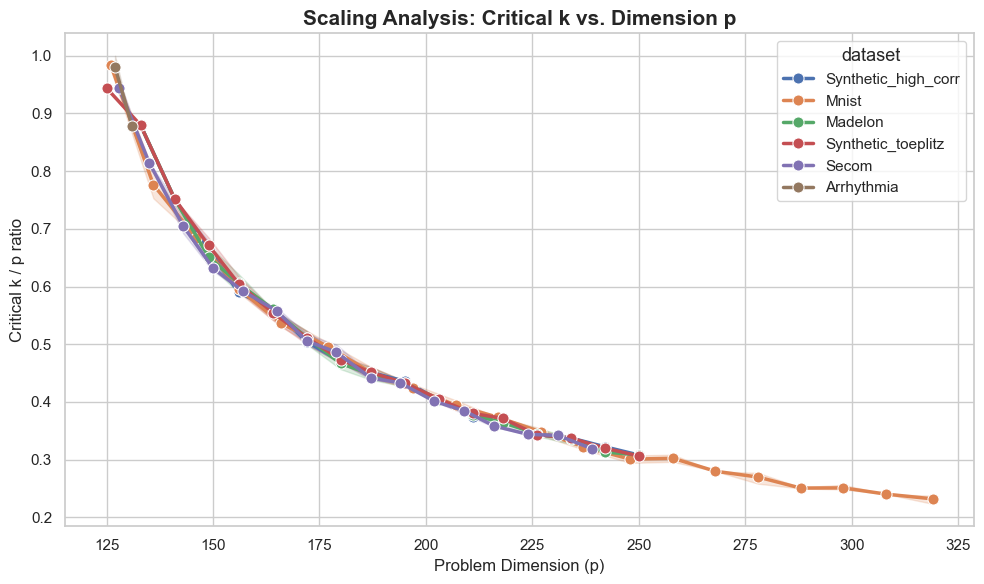

In [19]:
plot_p_ratio_time(df=df)

- Result implies taht as problem dimension increase, critical k / p ratio decreases.
- Critical k value is where we our algorihtm is faster than Greedy, maintaining an error threshold
- Implies for a big problem dimension, it's better?
- Useing n = 800, m = 100 set up

In [20]:
df

,timestamp,dataset,p,final_critical_k,speedup_at_k,ratio,relative_error,k_ratio
14,2026-02-01 03:55:58,Synthetic_high_corr,133,117,1.0154,1.0000,0.00,0.879699
15,2026-02-01 03:55:59,Synthetic_high_corr,141,106,1.0325,1.0000,0.00,0.751773
16,2026-02-01 03:56:03,Synthetic_high_corr,149,102,1.0130,1.0000,0.00,0.684564
17,2026-02-01 03:56:08,Synthetic_high_corr,156,92,0.9540,0.9999,0.01,0.589744
18,2026-02-01 03:56:13,Synthetic_high_corr,164,92,0.9850,1.0000,0.00,0.560976
...,...,...,...,...,...,...,...,...
974,2026-02-01 12:18:22,Arrhythmia,131,115,0.9588,1.0006,-0.06,0.877863
1003,2026-02-01 12:20:05,Arrhythmia,127,124,0.9520,1.0001,-0.01,0.976378
1004,2026-02-01 12:20:07,Arrhythmia,131,115,0.9617,1.0018,-0.18,0.877863
1033,2026-02-01 12:26:16,Arrhythmia,127,127,0.9531,1.0000,0.00,1.000000


In [21]:
def print_summary_table(df):
    """
    Aggregates 5 runs per p value into a clean table showing:
    - Critical k (Mean)
    - Speedup (Mean [Min - Max])
    - Relative Error (Mean [Min - Max])
    """
    # 1. Ensure required columns exist
    if 'relative_error' not in df.columns and 'ratio' in df.columns:
        df['relative_error'] = (1 - df['ratio']) * 100
    
    # 2. Define Aggregation Logic
    # We group by Dataset and Dimension (p)
    # For k: just take the mean (rounded)
    # For Speedup & Error: take mean, min, and max
    agg_rules = {
        'final_critical_k': ['mean'],
        'speedup_at_k': ['mean', 'min', 'max'],
        'relative_error': ['mean', 'min', 'max']
    }

    # Perform GroupBy
    grouped = df.groupby(['dataset', 'p']).agg(agg_rules)
    
    # 3. Flatten and Format the Data
    # The groupby creates a "MultiIndex" (e.g., speedup_at_k -> mean, min, max). 
    # We want to combine these into single readable strings.
    
    results = []
    
    for (dataset, p), row in grouped.iterrows():
        # Format k: "45"
        k_val = int(row[('final_critical_k', 'mean')])
        
        # Format Speedup: "2.35x (2.10-2.50)"
        s_mean = row[('speedup_at_k', 'mean')]
        s_min = row[('speedup_at_k', 'min')]
        s_max = row[('speedup_at_k', 'max')]
        speedup_str = f"{s_mean:.2f}x ({s_min:.2f}-{s_max:.2f})"
        
        # Format Error: "0.12% (-0.50 - 0.80)"
        e_mean = row[('relative_error', 'mean')]
        e_min = row[('relative_error', 'min')]
        e_max = row[('relative_error', 'max')]
        error_str = f"{e_mean:.2f}% ({e_min:.2f}-{e_max:.2f})"
        
        results.append({
            'Dataset': dataset,
            'Dim (p)': p,
            'Critical k (Avg)': k_val,
            'Speedup (Mean [Min-Max])': speedup_str,
            'Rel. Error (Mean [Min-Max])': error_str
        })

    # Create final dataframe
    summary_df = pd.DataFrame(results)
    
    # 4. Print
    print("\n=== Aggregated Results (5 Runs per Test) ===")
    pd.set_option('display.max_colwidth', None) # Ensure full string prints
    print(summary_df.to_string(index=False))
    
    return summary_df
print_summary_table(df)


=== Aggregated Results (5 Runs per Test) ===
            Dataset  Dim (p)  Critical k (Avg) Speedup (Mean [Min-Max]) Rel. Error (Mean [Min-Max])
         Arrhythmia      127               124        0.96x (0.95-0.97)         -0.00% (-0.01-0.00)
         Arrhythmia      131               115        0.96x (0.95-0.97)        -0.10% (-0.18--0.06)
            Madelon      133               117        1.02x (1.00-1.03)          0.05% (-0.03-0.22)
            Madelon      141               106        1.02x (0.99-1.04)          0.05% (-0.03-0.09)
            Madelon      149                97        0.99x (0.96-1.04)           0.31% (0.18-0.49)
            Madelon      156                94        1.00x (0.98-1.04)           0.32% (0.26-0.48)
            Madelon      164                92        1.02x (0.99-1.04)           0.40% (0.25-0.62)
            Madelon      172                88        1.00x (0.96-1.04)           0.35% (0.27-0.54)
            Madelon      180                84        

,Dataset,Dim (p),Critical k (Avg),Speedup (Mean [Min-Max]),Rel. Error (Mean [Min-Max])
0,Arrhythmia,127,124,0.96x (0.95-0.97),-0.00% (-0.01-0.00)
1,Arrhythmia,131,115,0.96x (0.95-0.97),-0.10% (-0.18--0.06)
2,Madelon,133,117,1.02x (1.00-1.03),0.05% (-0.03-0.22)
3,Madelon,141,106,1.02x (0.99-1.04),0.05% (-0.03-0.09)
4,Madelon,149,97,0.99x (0.96-1.04),0.31% (0.18-0.49)
...,...,...,...,...,...
82,Synthetic_toeplitz,218,81,1.04x (1.03-1.05),0.78% (0.51-1.02)
83,Synthetic_toeplitz,226,77,0.99x (0.96-1.01),0.77% (0.56-1.06)
84,Synthetic_toeplitz,234,79,1.01x (0.98-1.04),0.77% (0.50-1.03)
85,Synthetic_toeplitz,242,77,1.01x (0.96-1.04),0.63% (0.49-0.78)


## Test 5 - 2
With normal setting ($m = 50$, adaptive step number)



In [26]:
LOG_FILE = PROJECT_ROOT / "logs" / "time_crit_k_adaptive.csv"
PLOT_DIR = PROJECT_ROOT / "logs" / "plots"

print(f"Looking for log file at: {LOG_FILE}")

Looking for log file at: /Users/nautilus/gridfw/logs/time_crit_k_adaptive.csv


In [27]:
df = load_data()

# Plot k - accuracy

In [28]:
LOG_FILE = PROJECT_ROOT / "logs" / "accur_crit_k.csv"
df = load_data()
df = df[(df["speedup_at_k"] > 0.95) & (df["speedup_at_k"] < 1.05)]

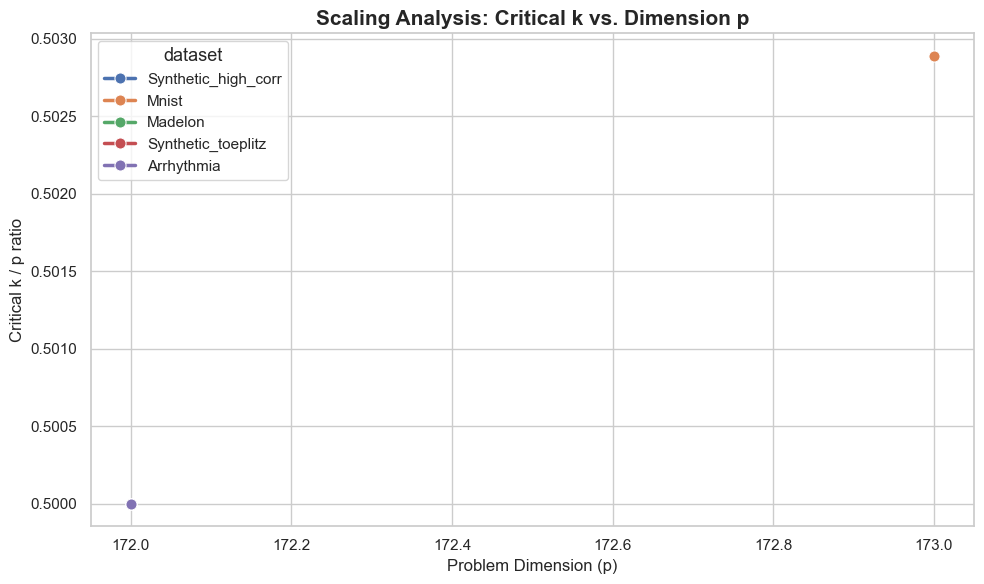

In [29]:
plot_p_ratio_time(df)

In [11]:

  
def plot_p_ratio_accur(df, p_limit=None):
    if p_limit:
        df = df[df["p"] < p_limit]
    # Also
    sns.set_theme(style="whitegrid")
    plt.figure(figsize=(10, 6))

    # 3. Create the Plot
    # Grouping by 'Dataset' happens automatically via the 'hue' parameter
    plot = sns.lineplot(
        data=df, 
        x='p', 
        y='k_ratio', 
        hue='dataset', 
        marker='o', 
        linewidth=2.5,
        markersize=8
    )

    # 4. Annotate and Beautify
    plt.title('Scaling Analysis: Critical k vs. Dimension p', fontsize=15, fontweight='bold')
    plt.xlabel('Problem Dimension (p)', fontsize=12)
    plt.ylabel('k_ratio', fontsize=12)
    plt.legend(title='dataset', title_fontsize='13', fontsize='11')

    # Optional: Force y-axis to start at 0
    # plt.ylim(0, df['Final_Critical_k'].max() * 1.1)


    plt.tight_layout()

    # 5. Save and Show
    # save_path = PROJECT_ROOT / "logs" / "plots" / "critical_k_time_p500.pdf"
    # save_path.parent.mkdir(parents=True, exist_ok=True)
    # plt.savefig(save_path, dpi=300)
    plt.show()



    

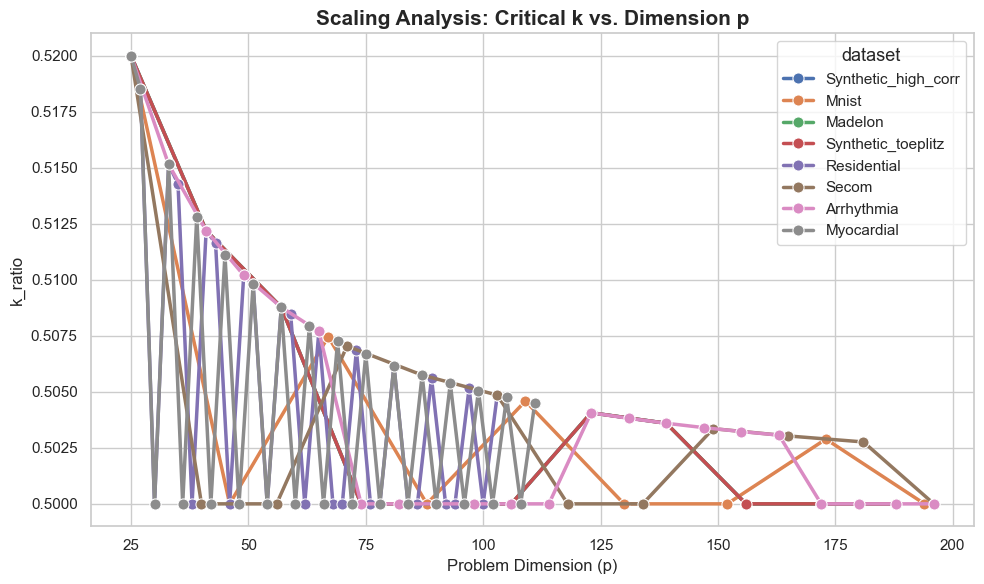

In [12]:
plot_p_ratio_accur(df, p_limit=200)

In [13]:
df = df[(df["Ratio"] > 0.95) & (df["Ratio"] < 1.05)]
df = df[df["p"] < 100]

sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))

# 3. Create the Plot
# Grouping by 'Dataset' happens automatically via the 'hue' parameter
plot = sns.lineplot(
    data=df, 
    x='p', 
    y='Final_Critical_k', 
    hue='Dataset', 
    marker='o', 
    linewidth=2.5,
    markersize=8
)

# 4. Annotate and Beautify
plt.title('Scaling Analysis: Critical k vs. Dimension p', fontsize=15, fontweight='bold')
plt.xlabel('Problem Dimension (p)', fontsize=12)
plt.ylabel('Critical k (Ratio ≈ 1.0)', fontsize=12)
plt.legend(title='Dataset', title_fontsize='13', fontsize='11')

# Optional: Force y-axis to start at 0
# plt.ylim(0, df['Final_Critical_k'].max() * 1.1)


plt.tight_layout()

# 5. Save and Show
save_path = PROJECT_ROOT / "logs" / "plots" / "critical_k_time.pdf"
save_path.parent.mkdir(parents=True, exist_ok=True)
plt.savefig(save_path, dpi=300)
plt.show()

KeyError: 'Ratio'

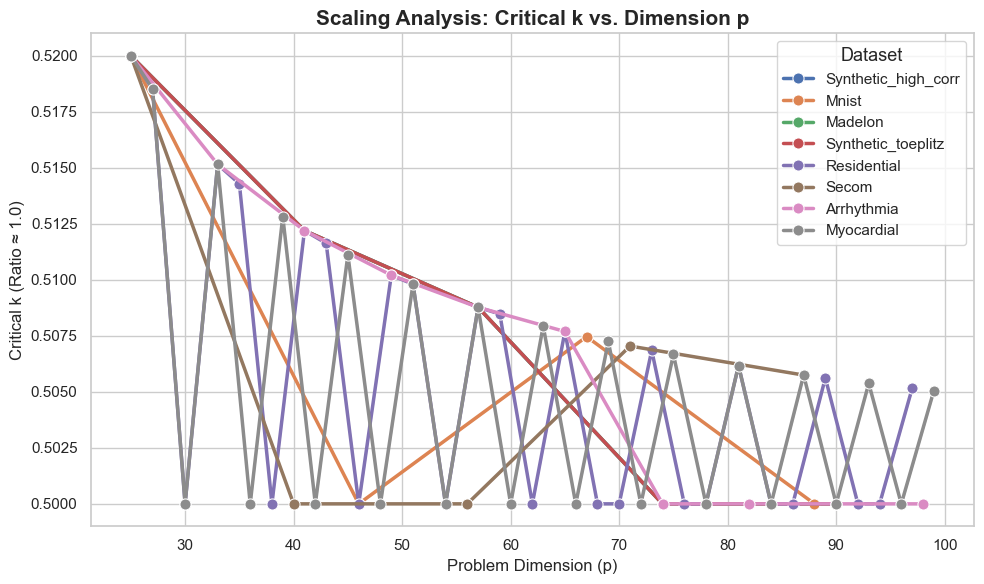

In [ ]:
df["kp_ratio"] = df["Final_Critical_k"] /  df["p"] 

sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))

# 3. Create the Plot
# Grouping by 'Dataset' happens automatically via the 'hue' parameter
plot = sns.lineplot(
    data=df, 
    x='p', 
    y='kp_ratio', 
    hue='Dataset', 
    marker='o', 
    linewidth=2.5,
    markersize=8
)

# 4. Annotate and Beautify
plt.title('Scaling Analysis: Critical k vs. Dimension p', fontsize=15, fontweight='bold')
plt.xlabel('Problem Dimension (p)', fontsize=12)
plt.ylabel('Critical k (Ratio ≈ 1.0)', fontsize=12)
plt.legend(title='Dataset', title_fontsize='13', fontsize='11')

# Optional: Force y-axis to start at 0
# plt.ylim(0, df['Final_Critical_k'].max() * 1.1)


plt.tight_layout()

# 5. Save and Show
save_path = PROJECT_ROOT / "logs" / "plots" / "critical_kp_ratio_accuracy.pdf"
save_path.parent.mkdir(parents=True, exist_ok=True)
plt.savefig(save_path, dpi=300)
plt.show()

## Test 5 - 2
With normal setting ($m = 50$, adaptive step number)

LOG_FILE = PROJECT_ROOT / "logs" / "time_crit_k_adaptive.csv"
PLOT_DIR = PROJECT_ROOT / "logs" / "plots"

print(f"Looking for log file at: {LOG_FILE}")

In [ ]:

LOG_FILE = PROJECT_ROOT / "logs" / "time_crit_k_adaptive.csv"
PLOT_DIR = PROJECT_ROOT / "logs" / "plots"

print(f"Looking for log file at: {LOG_FILE}")

NameError: name 'PROJECT_ROOT' is not defined